ctrl + f9 &emsp;&emsp; -> run all cells \
ctrl + M, B &emsp; -> create new cell

# 1. Import dependencies and data

In [3]:
# bringing in tensorflow
import tensorflow as tf

gpus = tf.config.experimental.list_physical_devices('GPU')

for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)

In [4]:
# tensorflow data sets for fashion mnist
import tensorflow_datasets as tfds
# matplotlib to visualize stuff
from matplotlib import pyplot as plt

c:\Users\dimau\Anaconda3\envs\clock\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [5]:
# use the tensorflow api to bting in the data sets
# specify that we only want the training partition
ds = tfds.load('fashion_mnist', split='train')
type(ds)

Dl Completed...: 0 url [00:00, ? url/s]
Dl Completed...:  50%|█████     | 2/4 [00:00<00:00,  2.17 url/s]

Dl Completed...:  75%|███████▌  | 3/4 [00:03<00:01,  1.12s/ url]

Dl Completed...: 100%|██████████| 4/4 [00:08<00:00,  2.45s/ url]

Dl Completed...: 100%|██████████| 4/4 [00:08<00:00,  2.13s/ url]


Dataset fashion_mnist downloaded and prepared to C:\Users\dimau\tensorflow_datasets\fashion_mnist\3.0.1. Subsequent calls will reuse this data.


tensorflow.python.data.ops.dataset_ops.PrefetchDataset

In [6]:
# ds.as_numpy_iterator().next() # dictionary
# contains the images and a label
ds.as_numpy_iterator().next().keys()

dict_keys(['image', 'label'])

# 2. Visualise data and build the pipeline

In [7]:
# good practice to always visualise your data

# do some data transformation
import numpy as np

In [8]:
# setup connection aka iterator
data_iterator = ds.as_numpy_iterator()

In [9]:
# getting data out of the pipeline
# data_iterator.next()
# data_iterator.next()['image'].shape # -> 28x28x1
# np.squeeze(data_iterator.next()['image']).shape # -> 28x28

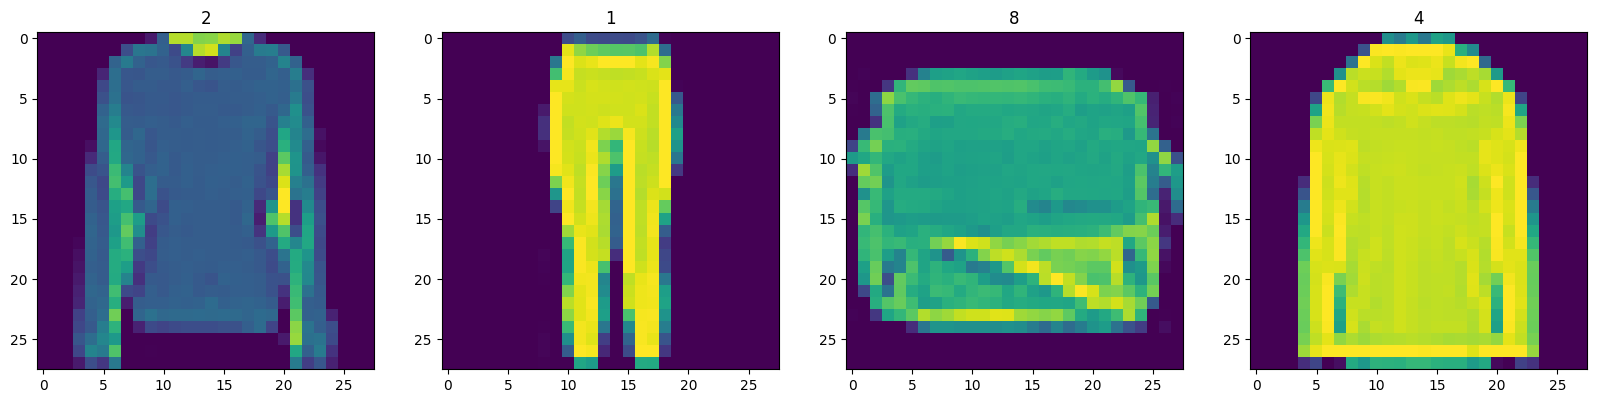

In [10]:
# setup the subplot formatting
fig, ax = plt.subplots(ncols=4, figsize=(20,20))
# loop 4 times anf get images
for idx in range(4):
  # grab an image and label
  batch = data_iterator.next()
  # batch = sample
  # plot the image using a specific subplot
  ax[idx].imshow(np.squeeze(batch['image']))
  # appending the image label as the plot title
  ax[idx].title.set_text(batch['label'])

In [11]:
# scale the images that have values [0, 255] to [0, 1]
# this is done so that we can have a model that trains
# and predicts a little bit faster

# we do not need the label as it is unsupervised learning
def scale_images(data):
  return data['image'] / 255

In [12]:
# load the dataset
ds = tfds.load('fashion_mnist', split='train')
# running the dataset through the scale_images preprocessing step
# overriding the values
ds = ds.map(scale_images)
# cache the dataset for that batch
ds = ds.cache()
# shuffle it up
# specifing what the shuffle buffer should be
ds = ds.shuffle(60000)
# batch into 128 images per sample
ds = ds.batch(128)
# reduces the liklihood of bottlenecking
ds = ds.prefetch(64)

In [13]:
ds.as_numpy_iterator().next().shape # -> 128x28x28x1

(128, 28, 28, 1)

# 3. Build the Neural Networks

### 3.1 Importing Modelling Components

In [14]:
# bring in the sequential api for the generator and discriminator
# squential -> 1 input 1 output
from keras.models import Sequential
# bring in the layers for the neural networks
from keras.layers import Conv2D, Dense, Flatten, Reshape, LeakyReLU, Dropout, UpSampling2D

### 3.2 Build Generator

In [15]:
def build_generator():
  model = Sequential()

  # 1. takes in random values and reshapes it to 7x7x128
  # input layer = dense fully conected layer
  # nr of units = 7 * 7 * 128
  # we are going to parse 128 random values to
  #   our generator to help it determine what
  #   to generate
  model.add(Dense(7*7*128, input_dim=128))
  model.add(LeakyReLU(0.2))
  model.add(Reshape((7,7,128)))

  # 2. upsampling block 1
  # doubles the last layer by 2 -> 14x14x128
  model.add(UpSampling2D())
  model.add(Conv2D(128, 5, padding='same'))
  model.add(LeakyReLU(0.2))

  # 3. upsampling block 2
  model.add(UpSampling2D())
  model.add(Conv2D(128, 5, padding='same'))
  model.add(LeakyReLU(0.2))

  # 4. convolutional block 1
  model.add(Conv2D(128, 4, padding='same'))
  model.add(LeakyReLU(0.2))

  # 5. convolutional block 2
  model.add(Conv2D(128, 4, padding='same'))
  model.add(LeakyReLU(0.2))

  # more blocks = more sophisticated NN, more params

  # 6. convolutional layer to get to one channel
  model.add(Conv2D(1, 4, padding='same', activation='sigmoid'))

  return model

In [30]:
generator = build_generator()
generator.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_2 (Dense)             (None, 6272)              809088    
                                                                 
 leaky_re_lu_9 (LeakyReLU)   (None, 6272)              0         
                                                                 
 reshape_1 (Reshape)         (None, 7, 7, 128)         0         
                                                                 
 up_sampling2d_2 (UpSampling  (None, 14, 14, 128)      0         
 2D)                                                             
                                                                 
 conv2d_9 (Conv2D)           (None, 14, 14, 128)       409728    
                                                                 
 leaky_re_lu_10 (LeakyReLU)  (None, 14, 14, 128)       0         
                                                      

1/1 [==============================] - 0s 242ms/step


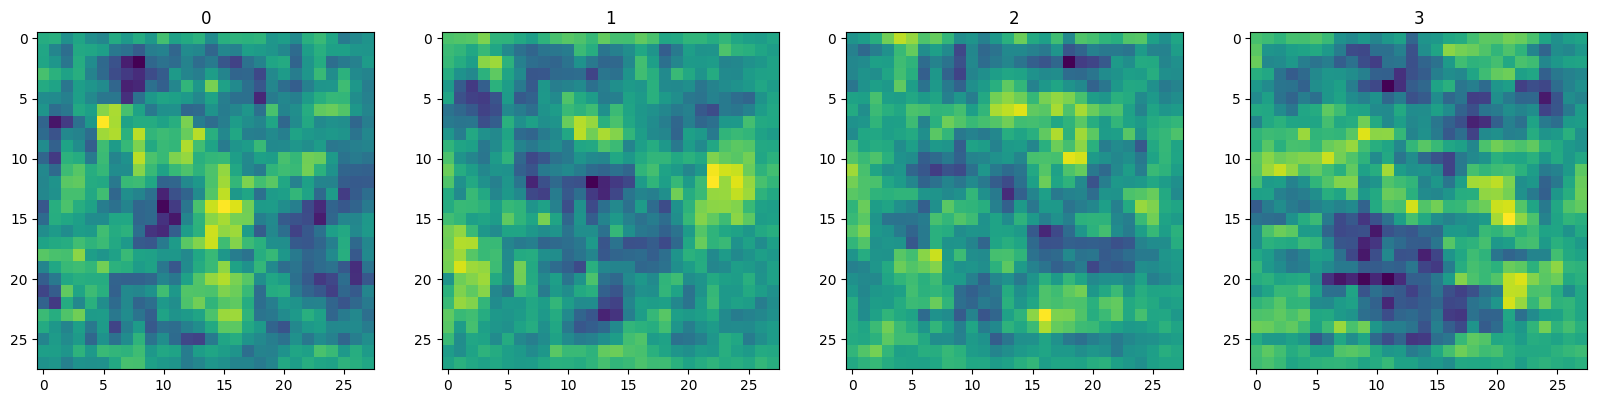

In [17]:
# generate new fashion
imgs = generator.predict(np.random.randn(4, 128, 1))
# print the images that we generated
fix, ax = plt.subplots(ncols=4, figsize=(20, 20))
for idx, img in enumerate(imgs):
  ax[idx].imshow(np.squeeze(img))
  ax[idx].title.set_text(idx)

### 3.3 Build Discriminator

In [18]:
def build_discriminator():
  model = Sequential()

  # 1. first convolutional block
  model.add(Conv2D(32, 5, input_shape=(28,28,1)))
  model.add(LeakyReLU(0.2))
  model.add(Dropout(0.4))

  # 2. second convolutional block
  model.add(Conv2D(64, 5))
  model.add(LeakyReLU(0.2))
  model.add(Dropout(0.4))

  # 3. third convolutional block
  model.add(Conv2D(128, 5))
  model.add(LeakyReLU(0.2))
  model.add(Dropout(0.4))

  # 4. fourth convolutional block
  model.add(Conv2D(256, 5))
  model.add(LeakyReLU(0.2))
  model.add(Dropout(0.4))

  # 5. flatten then pass to a dense layer
  model.add(Flatten())
  model.add(Dropout(0.4))
  model.add(Dense(1, activation='sigmoid'))

  return model

In [19]:
discriminator = build_discriminator()
# img.shape
discriminator.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_5 (Conv2D)           (None, 24, 24, 32)        832       
                                                                 
 leaky_re_lu_5 (LeakyReLU)   (None, 24, 24, 32)        0         
                                                                 
 dropout (Dropout)           (None, 24, 24, 32)        0         
                                                                 
 conv2d_6 (Conv2D)           (None, 20, 20, 64)        51264     
                                                                 
 leaky_re_lu_6 (LeakyReLU)   (None, 20, 20, 64)        0         
                                                                 
 dropout_1 (Dropout)         (None, 20, 20, 64)        0         
                                                                 
 conv2d_7 (Conv2D)           (None, 16, 16, 128)      

In [20]:
# the NN expects a batch of images
discriminator.predict(imgs)

1/1 [==============================] - 0s 108ms/step


array([[0.5044228],
       [0.5042067],
       [0.5041345],
       [0.5042683]], dtype=float32)

In [21]:
# if only one img:
img = imgs[0]
discriminator.predict(np.expand_dims(img, 0))

1/1 [==============================] - 0s 30ms/step


array([[0.5044227]], dtype=float32)

# 4. Construct Training Loop

In [22]:
# it is hard to train GAN's because you have to find the
# balance between the speed at which the discriminator
# trains and the speed at which the generator is able
# to learn

### 4.1 Setup Losses and Optimizers

In [23]:
# Adam is going to be the optimizer for both
from keras.optimizers import Adam
# Binary Crossentropy is going to be the loss func for both
from keras.losses import BinaryCrossentropy

In [24]:
g_opt = Adam(learning_rate=0.0001)
d_opt = Adam(learning_rate=0.00001)

g_loss = BinaryCrossentropy()
d_loss = BinaryCrossentropy()

### 4.2 Build Subclasses Model

In [25]:
# import the base model class to suclass our training step
from keras.models import Model

In [26]:
class FashionGAN(Model):
  def __init__(self, generator, discriminator, *args, **kwargs):
    # pass through args and kwargs to base class
    super().__init__(*args, **kwargs)

    # create attributes for gen and dis
    self.generator = generator
    self.discriminator = discriminator

  def compile(self, g_opt, d_opt, g_loss, d_loss, *args, **kwargs):
    # compile with base class
    super().compile(*args, **kwargs)

    # create attributes for losses and optimizers
    self.g_opt = g_opt
    self.d_opt = d_opt
    self.g_loss = g_loss
    self.d_loss = d_loss

  def train_step(self, batch):
    # get the data
    real_images = batch
    fake_images = self.generator(
        tf.random.normal((128, 128, 1)),
        training=False)
    # training=False means that Drouput layers do not activate

    # train the discriminator
    with tf.GradientTape() as d_tape:
      # pass the real and fake images to the discriminator model
      yhat_real = self.discriminator(real_images, training=True)
      yhat_fake = self.discriminator(fake_images, training=True)
      yhat_realfake = tf.concat([yhat_real, yhat_fake], axis=0)

      # create labels for real and fake images
      y_realfake = tf.concat([tf.zeros_like(yhat_real),
                              tf.ones_like(yhat_fake)], axis=0)

      # add some noise to the TRUE outputs
      noise_real = 0.15 * tf.random.uniform(tf.shape(yhat_real))
      noise_fake = -0.15 * tf.random.uniform(tf.shape(yhat_fake))
      y_realfake += tf.concat([noise_real, noise_fake], axis=0)

      # calculate loss - binarycrossentropy
      total_d_loss = self.d_loss(y_realfake, yhat_realfake)

    # apply backpropagation - NN learn
    dgrad = d_tape.gradient(total_d_loss,
                            self.discriminator.trainable_variables)
    self.d_opt.apply_gradients(zip(dgrad,
                            self.discriminator.trainable_variables))

    # train the generator
    with tf.GradientTape() as g_tape:
      # generate some new images
      gen_images = self.generator(
          tf.random.normal((128, 128, 1)),
          training=True)

      # create the predicted labels
      predicted_labels = self.discriminator(gen_images, training=False)

      # calculate loss - trick to training to fake out the discriminator
      total_g_loss = self.g_loss(tf.zeros_like(predicted_labels),
                                 predicted_labels)

    # apply backprop
    ggrad = g_tape.gradient(total_g_loss,
                            self.generator.trainable_variables)
    self.g_opt.apply_gradients(zip(ggrad,
                            self.generator.trainable_variables))

    return {"d_loss": total_d_loss, "g_loss": total_g_loss}

  def test_step(self):
    pass

In [27]:
# create instance of subclassed model
fashgan = FashionGAN(generator, discriminator)

In [28]:
# compile the model
fashgan.compile(g_opt, d_opt, g_loss, d_loss)

### 4.3 Build Callback

In [29]:
import os
from keras.preprocessing.image import array_to_img
from keras.callbacks import Callback

ImportError: cannot import name 'array_to_img' from 'keras.preprocessing.image' (c:\Users\dimau\Anaconda3\envs\clock\lib\site-packages\keras\preprocessing\image.py)

In [ ]:
class ModelMonitor(Callback):
  def __init__(self, num_img=3, latent_dim=128):
    self.num_img = num_img
    self.latent_dim = latent_dim

  def on_epoch_end(self, epoch, logs=None):
    random_latent_vectors = tf.random.uniform((self.num_img,
                                               self.latent_dim, 1))
    generated_images = self.model.generator(random_latent_vectors)
    generated_images *= 255
    generated_images.numpy()
    for i in range(self.num_img):
      img = array_to_img(generated_images[i])
      img.save(os.path.join('images', f'generated_img_{epoch}_{i}.png'))

### 4.4 Train

In [ ]:
# recommended 2000 epochs
hist = fashgan.fit(ds, epochs=20, callbacks=[ModelMonitor()])
# 20 epochs does nothing, I should train it over night and save it

### 4.5 Review Performance